In [1]:
# To create python file:
# jupyter nbconvert --to=python lang_model_new.ipynb

import utils.data_import as data_import
import utils.wiki_data as wiki_data
import utils.ml_utils as ml_utils
import model.neural as neural

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data, vocab

import os, sys
import pdb
import pandas as pd
import numpy as np
import math
#from tqdm import tnrange, tqdm_notebook
from tqdm import tqdm

import importlib

import settings

np.random.seed(123)

In [2]:
in_notebook = ml_utils.in_ipynb()
print('Running in notebook:', in_notebook)

Running in notebook: True


In [3]:
cuda = torch.cuda.is_available()
if cuda:
    print('Cuda is available!')
    print('Device:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('No cuda.')

if in_notebook:
    import matplotlib.pyplot as plt
    %matplotlib inline

No cuda.


In [4]:
corpus = wiki_data.WikiCorpus(file_path=settings.wikitext_path, lines=settings.lines)
corpus.vocab.export_vocab('vocab.p')

Generated train: 61,154 tokens (1,000 lines)
Generated valid: 54,147 tokens (1,000 lines)
Generated test:  65,832 tokens (1,000 lines)
Generated vocab: 10,954
Generated oov:   4.1%
Exporting vocab to vocab.p... Done.


In [5]:
corpus.batchify(batch_size=settings.batch_size, seq_length=settings.window_size)

Batchifying train... Done.  torch.Size([1223, 50])
Batchifying valid... Done.  torch.Size([1082, 50])
Batchifying test...  Done.  torch.Size([1316, 50])


3 3866 3 1624 869 346 3519 305 14 160 1894 149 10 62 1197 1791 278 1199 2685 23 2233 346 2186 44 3 3890 566 36 4186 93 3874 3875 62 16 1 3 44 2235 38 46 14 3 3850 902 44 18 3 850 848 3 4187 3 2080 127 62 3 671 127 2 3 4188 3 1668 62 563 14 4189 4190 16 3 None
<upcase> india <upcase> today criticized her acting skills , but remarked that : " [ she has ] managed to find her feet in <upcase> bollywood now by banking on glamorous roles " . <eol> <upcase> in 2008 and 2011 , <upcase> fernandez featured in the <upcase> uk magazine <upcase> eastern <upcase> eye 's " <upcase> world 's <unk> <upcase> asian <upcase> women " list , ranking twelfth . <upcase> None
tensor([ 17,  18,   3,   4,  16,   3, 434, 119, 283, 435, 234, 235,  14, 436,
        409,  79, 437,  23, 438,  81,  28, 439,   3,  82,  66, 387,  24,   3,
        440,   3,  83,  14, 441,  17, 442,   3, 421, 443,  16,   1,   3,  24,
         18,   3,  63, 396, 402, 158, 444,  14,  18, 445, 446,  17,  18,   3,
        384,   3, 385, 447, 

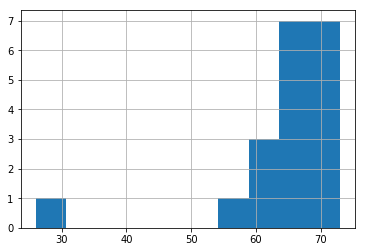

In [6]:
if in_notebook:
    print(corpus.train.show_itoklist(29629,29629+70))
    print(corpus.train.show_stoklist(corpus.vocab, 29629,29629+70))
    print(corpus.train.batch_matrix[:70,1])
    df = corpus.train.batch_stats()
    df.hist()

In [7]:
train_dl = wiki_data.WikiTextDataset(corpus.train)
valid_dl = wiki_data.WikiTextDataset(corpus.valid)
test_dl = wiki_data.WikiTextDataset(corpus.test)

In [8]:
model = neural.lang_model_LSTM(vocab_dim=len(corpus.vocab),
                               emb_dim=settings.emb_dim,
                               hidden_dim=settings.hidden_dim,
                               n_layers=settings.num_layers,
                               dropout=settings.dropout
                              )

In [9]:
if cuda:
    model = model.cuda()
loss_func = nn.CrossEntropyLoss()

In [10]:
print(model)

lang_model_LSTM(
  (embedding): Embedding(10954, 50)
  (lstm): LSTM(50, 300, num_layers=2, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=600, out_features=10954, bias=True)
  (dropout): Dropout(p=0.4)
)


In [11]:
model = torch.load('model_weights.pt')

In [12]:
missclass = []
missclass_next = []
losses = []

In [35]:
def run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
               losses=[], missclass=[]):
    
    opt = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-6)
    #opt = optim.Adam(model.parameters(), lr=0.001)
    
    
    scheduler = optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.8)
    
    best_missclass_te = 1e10
    
    try: # Allow for user interrupt
 
        for epoch in range(1, epochs + 1):
            scheduler.step()
            running_loss = 0.0
            running_corrects = 0
            model.train() # turn on training mode

            num_vals = 0
            num_correct = 0
            miss_next_wd = 0
            next_wd_tot = 0

            #pdb.set_trace()

            for x, y in tqdm(train_dl, desc='Train {}/{}'.format(epoch, epochs)):
                opt.zero_grad()
                
                if cuda:
                    x = x.cuda()
                    y = y.cuda()

                preds = model(x)
                loss = loss_func(preds.view(-1, preds.size(2)), y.view(-1).long())

                loss.backward()
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
                opt.step()

                running_loss += loss.item() * x.size(0) / x.size(1)

                _, y_preds = torch.max(preds, dim=2)
                num_correct += torch.sum(y == y_preds).item()
                num_vals += y.size(0)*y.size(1)
                
                miss_next_wd += ml_utils.calc_miss_next_wds(y, y_preds)
                next_wd_tot += y.size(1)

            #pdb.set_trace()

            missclass_tr = 1 - num_correct / num_vals
            miss_next_wd_rate_tr = miss_next_wd / next_wd_tot

            epoch_loss = running_loss / len(train_dl)

            num_vals = 0
            num_correct = 0
            miss_next_wd = 0
            next_wd_tot = 0

            # calculate the validation loss for this epoch
            val_loss = 0.0
            model.eval() # turn on evaluation mode
            
            with torch.no_grad():
                for x, y in tqdm(valid_dl, desc='Valid {}/{}'.format(epoch, epochs)):
                    if cuda:
                        x = x.cuda()
                        y = y.cuda()   
                        
                    preds = model(x)
                    loss = loss_func(preds.view(-1, preds.size(2)), y.view(-1).long())

                    val_loss += loss.item() * x.size(0) / x.size(1)

                    _, y_preds = torch.max(preds, dim=2)
                    num_correct += torch.sum(y == y_preds).item()
                    num_vals += y.size(0)*y.size(1)
                    
                    miss_next_wd += ml_utils.calc_miss_next_wds(y, y_preds)
                    next_wd_tot += y.size(1)

            #pdb.set_trace()

            missclass_te = 1 - num_correct / num_vals
            val_loss /= len(valid_dl)
            
            miss_next_wd_rate_val = miss_next_wd / next_wd_tot
            
            missclass_next.append((miss_next_wd_rate_tr, miss_next_wd_rate_val))
            missclass.append((missclass_tr, missclass_te))
            losses.append((epoch_loss, val_loss))

            print('Epoch: {}/{}, Loss: [{:.4f}, {:.4f}], Ppl: [{:6.2f}, {:6.2f}], Miss: [{:.2%}, {:.2%}], [{:.2%}, {:.2%}]'\
                  .format(epoch, epochs, epoch_loss, val_loss, 
                          math.exp(epoch_loss), math.exp(val_loss), 
                          missclass_tr, missclass_te,
                          miss_next_wd_rate_tr, miss_next_wd_rate_val))
            sys.stdout.flush()

            if missclass_te < best_missclass_te: 
                print('Saving weights file...', end=' ', flush=True)
                torch.save(model, 'model_weights.pt')
                print('Done.', flush=True)
                best_missclass_te = missclass_te
            
    except KeyboardInterrupt:
        print('Stopping with latest weights.')
        
    return model, opt, losses, missclass

In [36]:
model, opt, losses, missclass = run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
                                           losses=losses, missclass=missclass)

Valid 1/10: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]

Epoch: 1/10, Loss: [0.2622, 3.1644], Ppl: [  1.30,  23.68], Miss: [4.44%, 28.20%], [18.53%, 48.38%]
Saving weights file... Done.



Valid 2/10: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Epoch: 2/10, Loss: [0.2414, 3.1197], Ppl: [  1.27,  22.64], Miss: [4.13%, 28.09%], [14.84%, 48.75%]
Saving weights file... Done.



Valid 3/10: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

Epoch: 3/10, Loss: [0.1621, 3.0691], Ppl: [  1.18,  21.52], Miss: [2.68%, 27.82%], [12.11%, 49.12%]
Saving weights file... Done.



Valid 4/10: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

Epoch: 4/10, Loss: [0.1188, 3.0359], Ppl: [  1.13,  20.82], Miss: [1.89%, 27.48%], [10.42%, 48.38%]
Saving weights file... Done.



Valid 5/10: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

Epoch: 5/10, Loss: [0.1030, 3.0412], Ppl: [  1.11,  20.93], Miss: [1.62%, 27.40%], [11.68%, 49.12%]
Saving weights file... Done.



Valid 6/10: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]

Epoch: 6/10, Loss: [0.0946, 3.0447], Ppl: [  1.10,  21.00], Miss: [1.55%, 27.26%], [9.16%, 49.75%]
Saving weights file... Done.



Valid 7/10: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Epoch: 7/10, Loss: [0.0900, 3.0397], Ppl: [  1.09,  20.90], Miss: [1.44%, 27.31%], [8.74%, 48.25%]



Valid 8/10: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]

Epoch: 8/10, Loss: [0.0867, 3.0352], Ppl: [  1.09,  20.80], Miss: [1.40%, 27.16%], [7.16%, 48.38%]
Saving weights file... Done.



Valid 9/10: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]

Epoch: 9/10, Loss: [0.0848, 3.0657], Ppl: [  1.09,  21.45], Miss: [1.43%, 27.26%], [8.21%, 48.50%]



Valid 10/10: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]

Epoch: 10/10, Loss: [0.0843, 3.0702], Ppl: [  1.09,  21.55], Miss: [1.45%, 27.17%], [7.37%, 48.12%]


In [37]:
x, y = next(iter(valid_dl))
if cuda:
    x = x.cuda()
    y = y.cuda()
loss_func = nn.CrossEntropyLoss()
preds = model(x)
_, y_preds = torch.max(preds, dim=2)
ml_utils.calc_miss_next_wds(y, y_preds)
loss = loss_func(preds.view(-1, preds.size(2)), y.view(-1).long())
loss

tensor(2.3327, grad_fn=<NllLossBackward>)

In [38]:
print(y.shape)
print(y[:,2])

torch.Size([70, 50])
tensor([3792,   17,    3, 3688,    3,  411,    3,  500,   11,    3, 6689,   20,
           3, 6018,    3,  339,   44, 2029, 1704, 2558,   14,    3, 6689,    3,
        6676, 6690,    3, 2442,    3, 6686,  115, 2179,   23, 6691,   70,   18,
           3, 6692, 1704,    3, 6693,    2,   14,    3, 6694,    3, 1587,   17,
          18,    3, 3688,    3,  584,   44, 6691, 1704, 1846,   14,   38,    3,
        6689,    3,  543,    3,  339,   44, 6695, 1704, 6696,   16])


In [39]:
print(y_preds[:,2])

tensor([4751,   17,    3, 3688,    3,  411,    3, 2426,   11,    3, 2427,   20,
           3, 3941,    3, 2541,   44, 4314, 1704, 1098,   14,    3, 5079,    3,
         904,  905,    3, 2442,    3, 2786,  115, 2622,   23, 3591,   70,   18,
           3, 2993, 1704,    3, 4108,    2,   14,    3, 5079,    3, 1587,   17,
          18,    3, 3688,    3, 1733,   44, 2053, 1704, 4277,   14,   38,    3,
        4084,    3,  543,    3, 2541,   44, 2053, 1704, 4897,   18])


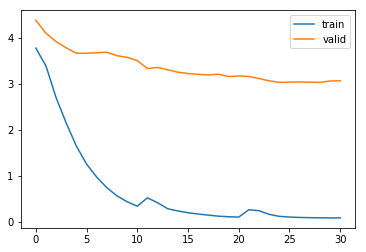

In [40]:
if in_notebook:
    plt.plot(losses)
    plt.legend(['train', 'valid'])

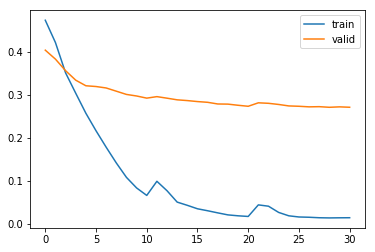

In [41]:
if in_notebook:
    plt.plot(missclass)
    plt.legend(['train', 'valid'])

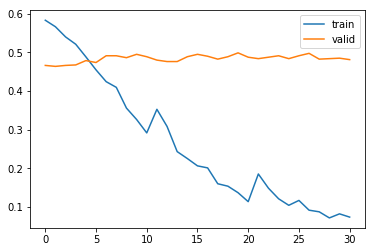

In [42]:
if in_notebook:
    plt.plot(missclass_next)
    plt.legend(['train', 'valid'])